In [1]:
!pip install numdifftools
import numdifftools as nd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Q1

In [2]:
u1, u2 = cp.Variable(nonneg=True), cp.Variable(nonneg=True)

In [3]:
# Initialize constraints (must be a list)

# u1 + 2u2 ≤ 12
# 2u1 + u2 ≤ 12
# u1 ≥ d1, u2 ≥ d2

d1,d2 = 3.5,2
constraints = [u1 + 2*u2 <= 12,
               2*u1 + u2 <= 12,
               u1 >= d1,
               u2 >= d2,
               ]

In [4]:
thetas = np.linspace(0,1,1000)

In [5]:
u1_theta = []
for θ in thetas:
  # u1, u2 = cp.Variable(nonneg=True), cp.Variable(nonneg=True)
  W = θ*u1 + (1-θ)*u2
  objective = cp.Maximize(W)
  problem = cp.Problem(objective, constraints)
  problem.solve()
  # print(problem.value)
  u1_theta.append(u1.value)
  
  

In [6]:
u1_theta[:10]

[3.5000000001610303,
 3.500000000161864,
 3.5000000001627027,
 3.500000000163548,
 3.5000000001643987,
 3.500000000165256,
 3.5000000001661182,
 3.500000000166986,
 3.5000000001678613,
 3.5000000001687415]

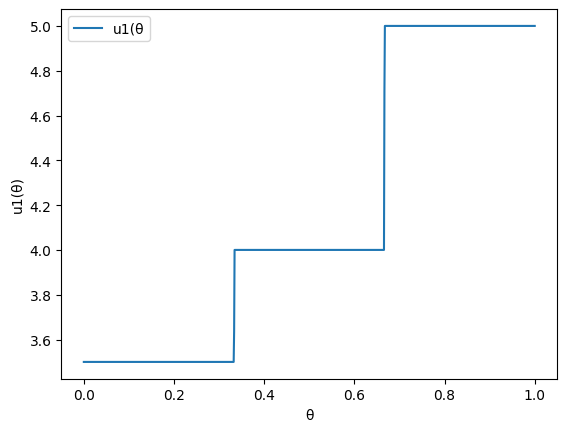

In [7]:
plt.plot(thetas, u1_theta,label="u1(θ")
plt.xlabel("θ")
plt.ylabel("u1(θ)")
plt.legend()
plt.show()

## Q2

In [8]:
u_1, u_2 = cp.Variable(), cp.Variable()
constraints = [u_1 + 2*u_2 <= 12,
               2*u_1 + u_2 <= 12,
               u_1 >= d1,
               u_2 >= d2,
               ]

In [9]:
N = cp.log(u_1 - d1) + cp.log(u_2 - d2)
objective = cp.Maximize(N)
problem = cp.Problem(objective, constraints)
problem.solve()

0.11778302005591901

In [10]:
print("Nash bargaining solution u1=",u_1.value," u2 = ",u_2.value)
print("Nash bargaining primal optimal value :",problem.value)

Nash bargaining solution u1= 4.249999934669844  u2 =  3.5000001072596256
Nash bargaining primal optimal value : 0.11778302005591901


In [11]:
# d1,d2 = 3.5,2
# constraints = [u1 + 2*u2 <= 12,
#                2*u1 + u2 <= 12,
#                u1 >= d1,
#                u2 >= d2,
#                ]
print("optimal (u1 + 2*u2 <= 12) dual variable =", constraints[0].dual_value)
print("optimal (2*u1 + u2 <=12 ) dual variable = ", constraints[1].dual_value)
print("optimal (u1 >= d1) dual variable = ", constraints[2].dual_value)
print("optimal (u2 >= d2) dual variable = ", constraints[3].dual_value)

optimal (u1 + 2*u2 <= 12) dual variable = 3.6170408140313444e-09
optimal (2*u1 + u2 <=12 ) dual variable =  0.6666667548200322
optimal (u1 >= d1) dual variable =  3.202879721090295e-09
optimal (u2 >= d2) dual variable =  1.5363574774749631e-09


In [12]:
d_1 = np.linspace(2,5,100)
soln = []
u1_list = []
u2_list = []
for i in d_1:
  N = cp.log(u_1 - i) + cp.log(u_2 - 2)
  objective = cp.Maximize(N)

  constraints_upadated = [u_1 + 2*u_2 <= 12,
               2*u_1 + u_2 <= 12,
               u_1 >= i,
               u_2 >= d2,
               ]

  problem = cp.Problem(objective, constraints_upadated)
  problem.solve()

  soln.append(problem.value)
  u1_list.append(u_1.value)
  u2_list.append(u_2.value)

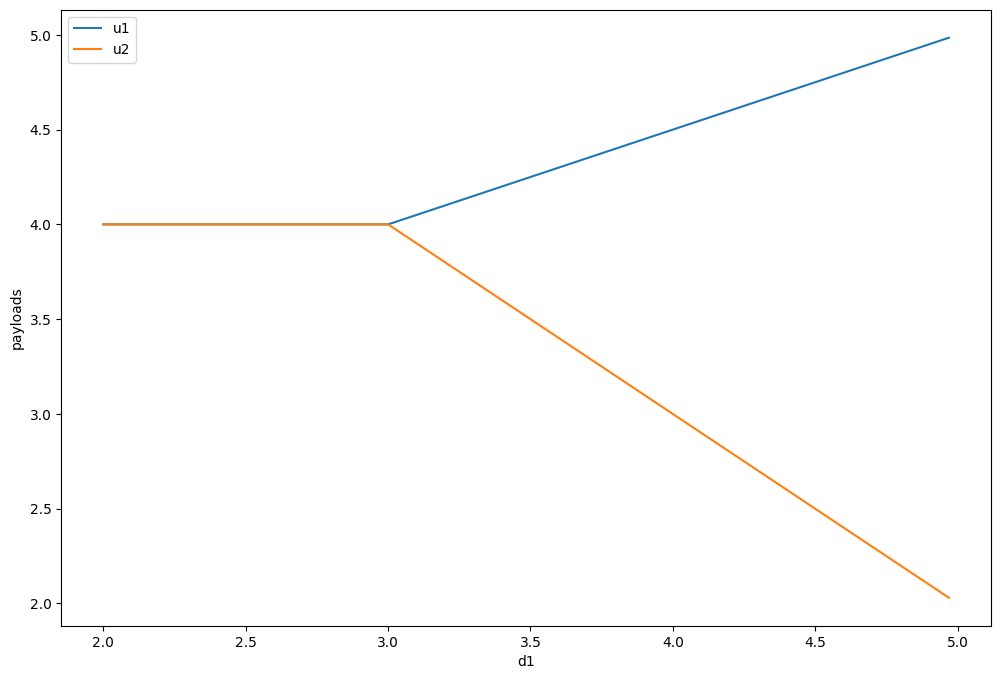

In [13]:
plt.figure(figsize=(12,8))
plt.plot(d_1,u1_list,label="u1")
plt.plot(d_1,u2_list,label="u2")
plt.xlabel("d1")
plt.ylabel("payloads")
plt.legend()

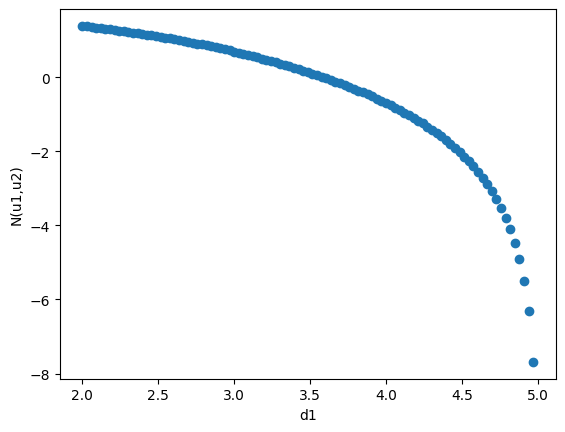

In [14]:
plt.scatter(d_1, soln)
plt.xlabel("d1")
plt.ylabel("N(u1,u2)")
# plt.legend()
plt.show()

## Q3

In [15]:
from scipy.optimize import line_search

def f0(x,y):
    return -(np.log(x-2)+np.log(y-1))
    # return -np.log((x-2)*(y-1))

def B(x,y):
  return (-np.log((-(x+2*y-12))))+ (-np.log((-(2*x+y-12)))) + (-np.log(x-2)) + (-np.log(y-1)) 
  # return - np.log((x+2*y-12)*(2*x+y-12)*(x-2)*(y-1))???
  
def f(x,y,t):
  # return -t*(np.log(x-2)+np.log(y-1)) - (np.log(12-x-2*y)+np.log(12-2*x-y)+np.log(x-2)+np.log(y-1))
  return t*f0(x,y)+B(x,y)


# computing first order derivatives of f wrt x and y
def df(x,y,t):
  dx = (-t/(x-2)) - (1/(x-2)) + (1/(-x-2*y+12)) + (2/(-2*x-y+12))
  dy = (-t/(y-1)) - (1/(y-1)) + (2/(-x-2*y+12)) + (1/(-2*x-y+12))
  return dx,dy

# constructing Hessian matrix (inbuilt func and by calculating each derivative)
def Hessian(x,y,t):
  hessian = np.zeros((2,2),dtype=float)
  hessian[0][0]  = (t/((x-2)**2)) + ( (1/((x+2*y-12)**2)) + (4/(2*x+y-12)**2) + (1/((x-2)**2)) )
  hessian[1][1]  = (t/((y-1)**2)) + ( (4/((x+2*y-12)**2)) + (1/(2*x+y-12)**2) + (1/((y-1)**2)) )
  hessian[1][0]= hessian[0][1] =   ( (2/((x+2*y-12)**2)) + (2/((2*x+y-12)**2)) )
  return hessian

def lineSearch(x,y,t,alpha,beta,d1,d2):
  tx=ty= 1
  dx,dy = df(x,y,t)

  Df_t = tx*d1*dx + ty*d2*dy
  

  while( f(x,y,t) - f(x+tx*d1,y+ty*d2,t) < - alpha*(Df_t) ):
    # print(f(x,y,t))
    tx = beta * tx
    ty = beta * ty
    Df_t = tx*d1*dx + ty*d2*dy

  return tx,ty

# return bool wheter the given matrix is positive definite 



def newtonDescent(x,y,t,tol,alpha,beta):
  dx,dy = df(x,y,t)  
  Hf = Hessian(x,y,t)
  gradient_f = np.array([[dx],[dy]])

  # Choosing Directional Derivatives
  d = np.matmul(np.linalg.inv(Hf),(-gradient_f ))
  norm = math.sqrt((dx)**2 + (dy)**2) 
  while(norm>tol):  # while norm of gradient is greater than tolerance
      d1,d2 = d[0][0],d[1][0]
      # line search
      tx,ty = lineSearch(x,y,t,alpha,beta,d1,d2)
      
      # x = x + td (updating)
      x = x + tx * d1
      y = y + ty * d2
      # print(x,y,norm,f(x,y,t),d1,d2,tx,ty)
      
      # updating derivatives,Hessian Matrix,gradient,norm
      dx,dy = df(x,y,t)
      Hf = Hessian(x,y,t)
      gradient_f = np.array([[dx],[dy]])
      d = np.matmul(np.linalg.inv(Hf),-gradient_f )
      norm = math.sqrt((dx)**2 + (dy)**2) 

  return x,y

alpha = 0.1
beta = 0.8
tol = 1e-3
ux,uy = 3.5,3.5
t = 2
μ = 11
m = 4
η = 1e-6
c = 0



while m/t > η:
  # print(c)
  t = μ*t
  # centering
  u1_min,u2_min = newtonDescent(ux,uy,t,tol,alpha,beta)
  # print(u1_min,u2_min)
  ux,uy = u1_min,u2_min
  c+=1
  print("---------------------------------")

print(ux,uy)

---------------------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
59746897774.591415 72627271714.19226


In [16]:
# Algorithm: Interior point (log barrier)
# choose an initial strictly feasible primal point x, an initial value t = t0 of the accuracy
# parameter, the accuracy multiplier μ > 1 (usually a value between 10 to 20), a tolerance
# level η for the stopping criterion
# while m/t > η (current iterate is not within η-suboptimal)
# 1. Increase accuracy. t = μt
# 2. Centering step. Compute the central point x(t) by solving (12.5) using Newton descent
# method and x as the initial point.
# 3. Update the initial point for next iteration. x = x(t)
# endwhile
# return x as the primal optimum; and λi = −  1./t_fi(x)
# as the i-th dual optimum
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import numpy as np

intial_t = t = 2
μ = 11
η = 1e-6
m = 4
alpha = 0.1
beta = 0.5
tol = 1e-5
x = [3.01,3.01]
c = 0
final_t = 2+1e-9
while m/final_t > η:
  final_t = μ*final_t

def check_positive_def(matrix):
    w, v = np.linalg.eig(matrix)
    return all(eigenvalue > 0 for eigenvalue in w)



def jacobian(x,y,t):
  dx = (-t/(x-2)) - (1/(x-2)) + (1/(-x-2*y+12)) + (2/(-2*x-y+12))
  dy = (-t/(y-1)) - (1/(y-1)) + (2/(-x-2*y+12)) + (1/(-2*x-y+12))
  res = np.array([dx,dy])
  # print(res.shape)
  return res


while m/t > η:
  t = μ*t
  # centering
  fun = lambda x: -t*(np.log(x[0]-2) + np.log(x[1]-1)) + (-np.log((-(x[0]+2*x[1]-12)))+ (-np.log((-(2*x[0]+x[1]-12)))) + (-np.log(x[0]-2)) + (-np.log(x[1]-1)) )
  bnds = ((2, 4), (1, 4))
  # print(fun(x))
  # jacb = lambda x: approx_fprime(x,fun,0.001)
  jacb = lambda x: jacobian(x[0],x[1],t)
  res = minimize(fun,x,method='Newton-CG',jac = jacb)
  x = res.x
  # print(x)
  # print(res.x)
  break
  # ux_min,uy_min = combinationGradient(ux,uy,t,tol,alpha,beta)
  # print(ux_min,uy_min)
  # ux,uy = ux_min,uy_min
  
  c+=1
  


# u1_min,u2_min = x[0],x[1]
u1,u2 = x[0],x[1]
print(u1,u2)
# ux,uy = ux_min,uy_min

4.035788415089387 3.716072253920001


In [17]:
# (i)
print("Intial t:",intial_t)
print("Final  t:",final_t)

Intial t: 2
Final  t: 38974342.01948718


In [18]:
# Nash Bargainin solution
print("Nash bargaining solution u1=",u1," u2 = ",u2)

Nash bargaining solution u1= 4.035788415089387  u2 =  3.716072253920001


In [19]:
# primal optimal value (Maximized Nash welfare)
print("Nash bargaining primal optimal value :",np.log(u1-2)+np.log(u2-1))

Nash bargaining primal optimal value : 1.7100699838321547


In [25]:
# dual optimum
# -1/(t*f(xi))

print("optimal (u1 + 2*u2 <= 12) dual variable =", -1 / ((u1 + 2*u2-12)*final_t)  )
print("optimal (2*u1 + u2 <=12 ) dual variable = ", -1/((2*u1 + u2 - 12 )*final_t) )
print("optimal (u1 >= d1) dual variable = ",  -1/(final_t*(2-u1)))
print("optimal (u2 >= d2) dual variable = ", -1/(final_t*(1-u2)))

optimal (u1 + 2*u2 <= 12) dual variable = 4.8223066234375005e-08
optimal (2*u1 + u2 <=12 ) dual variable =  1.2082785605050583e-07
optimal (u1 >= d1) dual variable =  1.2603424652841342e-08
optimal (u2 >= d2) dual variable =  9.446694896159456e-09


In [26]:
# inequality constraint function values at the optimum
print("(u1 + 2*u2 <= 12) value =", ((u1 + 2*u2-12))  )
print("(2*u1 + u2 <=12 )  variable = ", ((2*u1 + u2 - 12 )) )
print("(u1 >= d1)  variable = ",  ((2-u1)))
print(" (u2 >= d2)  variable = ", ((1-u2)) )

(u1 + 2*u2 <= 12) value = -0.5320670770706108
(2*u1 + u2 <=12 )  variable =  -0.2123509159012258
(u1 >= d1)  variable =  -2.035788415089387
 (u2 >= d2)  variable =  -2.716072253920001


In [22]:
u1_, u2_ = cp.Variable(), cp.Variable()
d1,d2 = 2,1
constraints_x = [u1_ + 2*u2_ <= 12,
               2*u1_ + u2_ <= 12,
               u1_ >= d1,
               u2_ >= d2,
               ]

N = cp.log(u1_ - 2) + cp.log(u2_ - 1)
objective = cp.Maximize(N)
problem = cp.Problem(objective, constraints_x)
problem.solve()
print("Nash bargaining solution u1=",u1_.value," u2 = ",u2_.value)
print("Nash bargaining primal optimal value :",problem.value)


Nash bargaining solution u1= 4.000000004979701  u2 =  3.9999999269662188
Nash bargaining primal optimal value : 1.7917594473733116


In [23]:
print("optimal (u1 + 2*u2 <= 12) dual variable =", constraints_x[0].dual_value)
print("optimal (2*u1 + u2 <=12 ) dual variable = ", constraints_x[1].dual_value)
print("optimal (u1 >= d1) dual variable = ", constraints_x[2].dual_value)
print("optimal (u2 >= d2) dual variable = ", constraints_x[3].dual_value)

optimal (u1 + 2*u2 <= 12) dual variable = 0.055555492917319045
optimal (2*u1 + u2 <=12 ) dual variable =  0.22222225382821226
optimal (u1 >= d1) dual variable =  2.6347836197701797e-09
optimal (u2 >= d2) dual variable =  1.8187904014581112e-09


In [24]:
print("(u1 + 2*u2 <= 12) value =", ((u1_.value + 2*u2_.value-12))  )
print("(2*u1 + u2 <=12 )  variable = ", ((2*u1_.value + u2_.value - 12 )) )
print("(u1 >= d1)  variable = ",  ((2-u1_.value)))
print(" (u2 >= d2)  variable = ", ((1-u2_.value)) )

(u1 + 2*u2 <= 12) value = -1.4108786139388485e-07
(2*u1 + u2 <=12 )  variable =  -6.307437949715222e-08
(u1 >= d1)  variable =  -2.000000004979701
 (u2 >= d2)  variable =  -2.9999999269662188
